# Results

Processing & Visualisation of the project results.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader
import pandas as pd
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cpu


In [3]:
from utils.model_utils import read_csv_data, CustomDataset, load_model, Testing
from utils.geojson_utils import Neighborhoods

/home/florsanders/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Figures directory
figures_dir = "./figures"
os.makedirs(figures_dir, exist_ok=True)

In [5]:
format_borough = lambda s: s.replace(" ", "_").lower()
class_map = {"bronx" : 0, "brooklyn": 1,"manhattan": 2, "queens": 3, "staten_island": 4}
inverse_class_map = {0: "Bronx", 1: "Brooklyn", 2: "Manhattan", 3: "Queens", 4: "Staten Island"}

In [6]:
# Test data
_, _, test_df = read_csv_data("./data/all/data.csv")
test_set = CustomDataset(test_df)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)
test_df.head()

/home/florsanders/Code/columbia_university/deep_learning_for_computer_vision/project/utils/model_utils.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  path = df.iloc[index][0]
/home/florsanders/Code/columbia_university/deep_learning_for_computer_vision/project/utils/model_utils.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  category = df.iloc[index][1]


,path,borough,id,longitude,latitude
35080,./data/all/Brooklyn/391667738085900.jpg,Brooklyn,391667738085900,-73.993418,40.630333
33250,./data/all/Brooklyn/702979062056016.jpg,Brooklyn,702979062056016,-73.913657,40.609021
9784,./data/all/Bronx/488840315694611.jpg,Bronx,488840315694611,-73.877197,40.893797
29385,./data/all/Queens/477917698479098.jpg,Queens,477917698479098,-73.782810,40.753708
35760,./data/all/Manhattan/851067596596194.jpg,Manhattan,851067596596194,-73.988766,40.716325


In [7]:
# Models
format_label = lambda s: s.replace("(", "").replace(")", "").replace(" ", "_").lower()
models_dir = "./models"
model_configs = [
    {
        "weights": "weights_custom.pth",
        "architecture": "benchmark",
        "label": "CNN Benchmark",
    },
    {
        "weights": "resnet18_places_5_-2_alone.pth",
        "architecture": "resnet18",
        "label": "Resnet18 (Places365)",
    },
    {
        "weights": "resnet18_20+5_cont.pth",
        "architecture": "resnet18",
        "label": "Resnet18 (ImageNet)",
    },
    {
        "weights": "regnet_5_alone.pth",
        "architecture": "regnet_y_1_6gf",
        "label": "Regnet (ImageNet)",
    },
    {
        "weights": "resnet50_5_alone.pth",
        "architecture": "resnet50",
        "label": "Resnet50 (ImageNet)",
    },
]

### Benchmarks

In [8]:
y_true = np.array([class_map[format_borough(b)] for b in test_df["borough"]])

In [9]:
# random choices
np.random.seed(1234)
y_hat_random = np.random.randint(5, size=len(test_df))
print(y_hat_random)
random_accuracy = np.mean(y_true == y_hat_random)
print(f"Random picks accuracy = {random_accuracy * 100:.2f} %")

[3 4 4 ... 3 2 1]
Random picks accuracy = 20.71 %


In [10]:
# random choices with prior
np.random.seed(1234)
priors = np.load("./models/priors.npy")
classes = np.arange(len(priors))
y_hat_prior = np.random.choice(classes, p=priors, size=len(test_df))
print(y_hat_prior)
prior_accuracy = np.mean(y_true == y_hat_prior)
print(f"Prior picks accuracy = {prior_accuracy * 100:.2f} %")

[1 3 2 ... 0 2 3]
Prior picks accuracy = 24.48 %


### Test Models

The code fields below load our trained models and evaluate their performance against the test set.  

- The weights of our pretrained models are available on [Google Drive](https://drive.google.com/file/d/1h0h4MQMAgINH07Pp93Ap7VjfJB02hGxw/view?usp=drive_link) and should be placed in the `models` directory for correct operation.
- Alternatively, note that the last cell allows reading the precomputed results from disk. 

In [ ]:
# Test models
model_accuracies = [None] * len(model_configs)
model_ys = [None] * len(model_configs)
model_y_hats = [None] * len(model_configs)

for i, model_config in enumerate(model_configs):
    # Parse config
    model_label = model_config["label"]
    print(f"Testing model: {model_label}")

    # Load model
    model, model_transforms = load_model(model_config, models_dir)
    dataset = "places" if "Places365" in model_label or model_config["architecture"] == "benchmark" else "imagenet"

    # Test model
    figure_path = os.path.join(figures_dir, f"mistakes_{format_label(model_label)}.png")
    accuracy, y, y_hat = Testing(test_loader, model, model_transforms, dataset=dataset, display=True, figure_path=figure_path)

    # Save results
    model_accuracies[i] = accuracy
    model_ys[i] = y
    model_y_hats[i] = y_hat

In [ ]:
# Save model results
model_results_path = "./models/results"
os.makedirs(model_results_path, exist_ok=True)

# Convert results to arrays
model_accuracies = np.array(model_accuracies)
model_ys = np.array(model_ys)
model_y_hats = np.array(model_y_hats)
print(f"Accuracies = {model_accuracies * 100}")

# Save results
np.save(os.path.join(model_results_path, "accuracy.npy"), model_accuracies)
np.save(os.path.join(model_results_path, "y.npy"), model_ys)
np.save(os.path.join(model_results_path, "y_hat.npy"), model_y_hats)

Run this cell to load the results from disk

In [11]:
# Load results
model_results_path = "./models/results"
model_accuracies = np.load(os.path.join(model_results_path, "accuracy.npy"))
model_ys = np.load(os.path.join(model_results_path, "y.npy"))
model_y_hats = np.load(os.path.join(model_results_path, "y_hat.npy"))
# Make sure the order between model ys & df ys is identical
y = np.squeeze(model_ys[0])
assert np.all(y == y_true), "The order of the training df and the model results is not the same!"

### Game Results

The code fields below load the log results from the RecogNYCe videogame. These will be used to gauge the performance of human players.

In [12]:
logs_path = os.path.join("./webapp/api/log.csv")
logs_df = pd.read_csv(logs_path)
print(f"{len(logs_df) = }")

len(logs_df) = 1406


In [13]:
logs_df["y"] = logs_df["label"].apply(lambda label: class_map[label])
logs_df["y_hat"] = logs_df["guess"].apply(lambda label: class_map[label])
logs_df["correct"] = logs_df["y"] == logs_df["y_hat"]
logs_df = logs_df.join(test_df.set_index("id"), on="img_id")

In [14]:
logs_df.head()

,timestamp,user_id,img_id,label,guess,y,y_hat,correct,path,borough,longitude,latitude
0,20231124_144500,2988a436-d081-4dcf-b8e3-67e1b60ca931,2246842352113142,queens,queens,3,3,True,./data/all/Queens/2246842352113142.jpg,Queens,-73.795231,40.705950
1,20231124_144503,2988a436-d081-4dcf-b8e3-67e1b60ca931,419723621199216,bronx,brooklyn,0,1,False,./data/all/Bronx/419723621199216.jpg,Bronx,-73.907518,40.855807
2,20231124_144508,2988a436-d081-4dcf-b8e3-67e1b60ca931,365967006594992,brooklyn,bronx,1,0,False,./data/all/Brooklyn/365967006594992.jpg,Brooklyn,-73.937889,40.691131
3,20231124_144513,2988a436-d081-4dcf-b8e3-67e1b60ca931,13824122226053,queens,queens,3,3,True,./data/all/Queens/13824122226053.jpg,Queens,-73.871632,40.739891
4,20231124_144520,2988a436-d081-4dcf-b8e3-67e1b60ca931,557202832476989,queens,staten_island,3,4,False,./data/all/Queens/557202832476989.jpg,Queens,-73.867128,40.706071


### Visualize Results

#### Global Stats

In [15]:
for model_config, accuracy in zip(model_configs, model_accuracies):
    print(f"{model_config['label']} Accuracy = {accuracy*100:.2f} %")

logs_accuracy = np.mean(logs_df["correct"].to_numpy())
print(f"Players Accuracy = {logs_accuracy * 100:.2f} % ")

CNN Benchmark Accuracy = 41.18 %
Resnet18 (Places365) Accuracy = 62.72 %
Resnet18 (ImageNet) Accuracy = 60.16 %
Regnet (ImageNet) Accuracy = 60.86 %
Resnet50 (ImageNet) Accuracy = 62.97 %
Players Accuracy = 34.64 % 


#### By Location

In [16]:
# Load geojson of NYC boroughs
geo_path = os.path.join("./data/location/nyc_boroughs.geojson")
nb = Neighborhoods()
nb.load_geojson(geo_path)

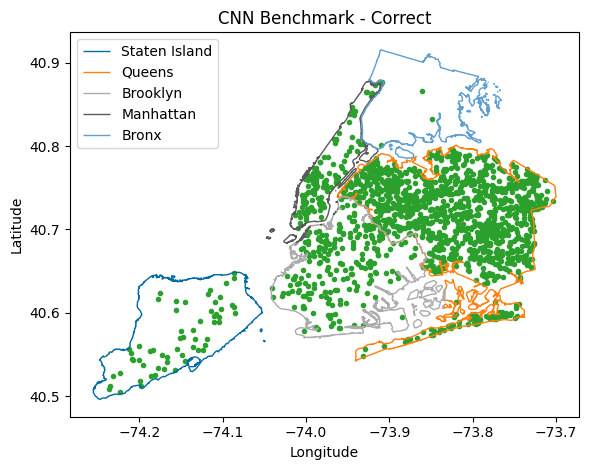

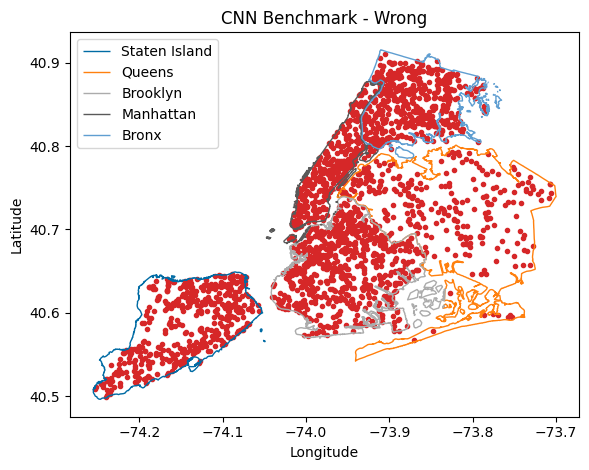

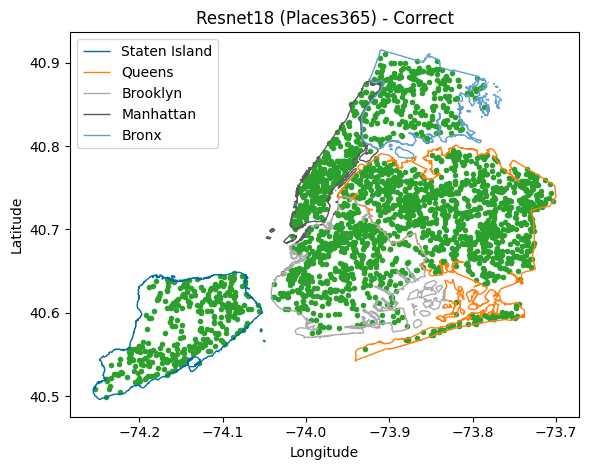

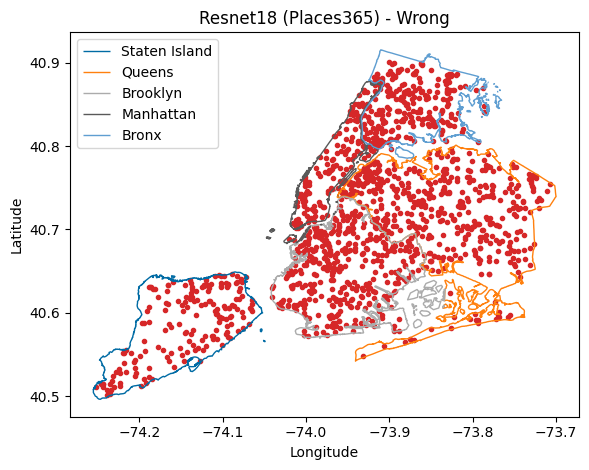

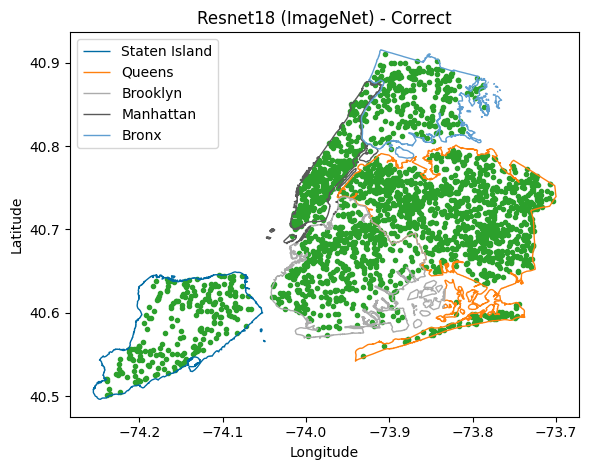

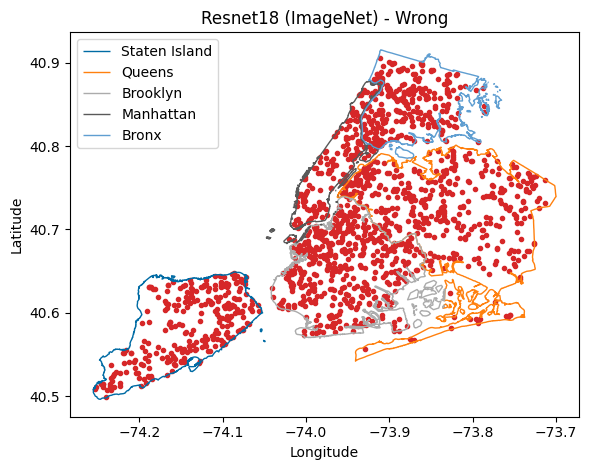

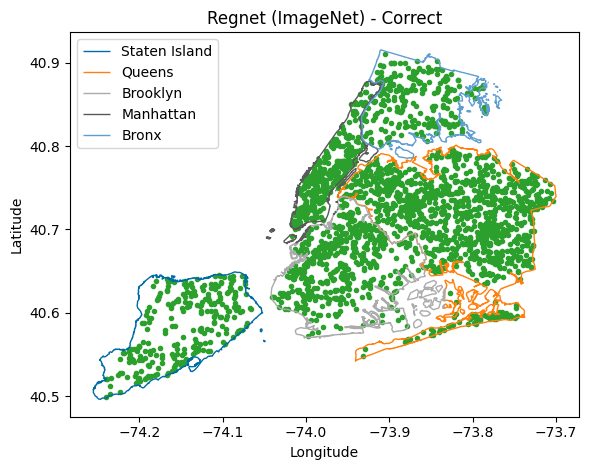

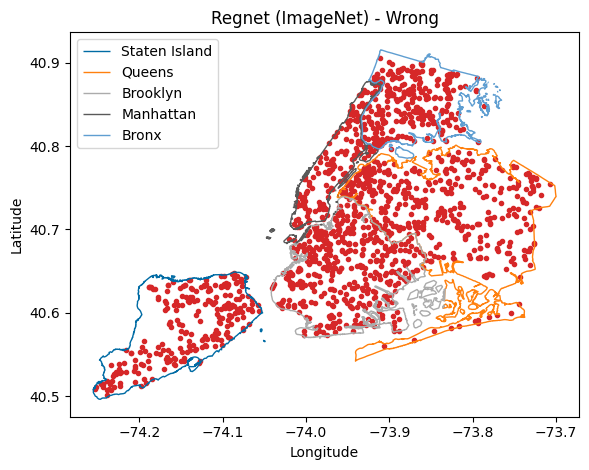

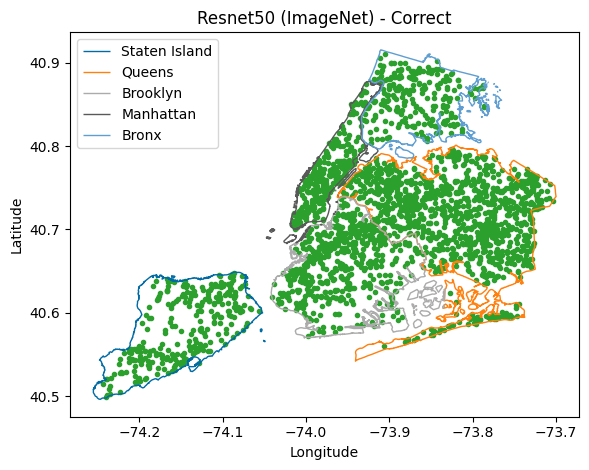

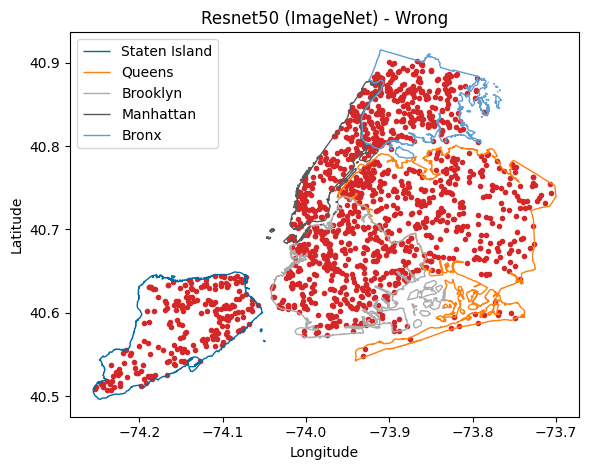

In [17]:
# Plots for models
for i, model_config in enumerate(model_configs):
    model_label = model_config["label"]

    fig_correct, ax_correct = plt.subplots()
    fig_wrong, ax_wrong = plt.subplots()

    ax_correct = nb.plot(ax=ax_correct)
    ax_wrong = nb.plot(ax=ax_wrong)

    model_correct = np.argmax(model_y_hats[i], axis=-1) == np.squeeze(model_ys[i])
    correct_df = test_df[model_correct == True]
    wrong_df = test_df[model_correct == False]

    ax_correct.scatter(correct_df["longitude"], correct_df["latitude"], c="tab:green", marker=".")
    ax_correct.legend()
    ax_correct.set_title(f"{model_label} - Correct")
    fig_correct.tight_layout()
    ax_wrong.scatter(wrong_df["longitude"], wrong_df["latitude"], c="tab:red", marker=".")
    ax_wrong.legend()
    ax_wrong.set_title(f"{model_label} - Wrong")
    fig_wrong.tight_layout()

    fig_correct.savefig(os.path.join(figures_dir, f"map_{format_label(model_label)}_correct.png"), dpi=300, facecolor="white")
    fig_wrong.savefig(os.path.join(figures_dir, f"map_{format_label(model_label)}_wrong.png"), dpi=300, facecolor="white")
    plt.show()

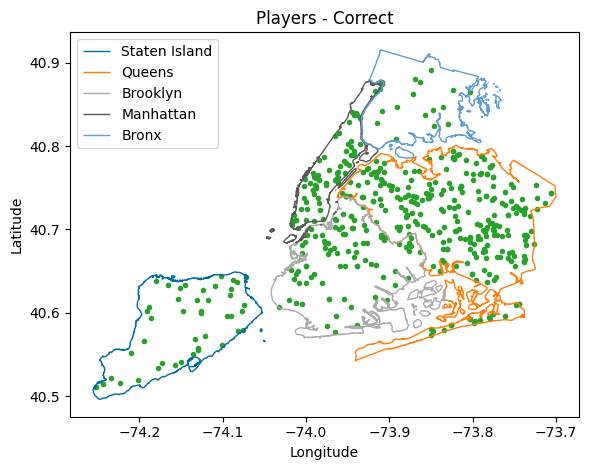

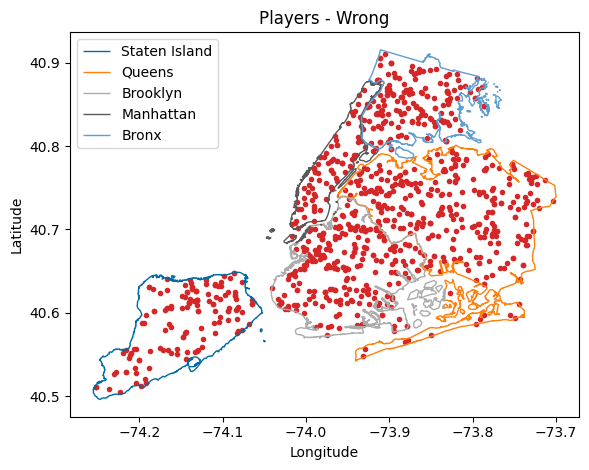

In [18]:
# Plot for players
fig_correct, ax_correct = plt.subplots()
fig_wrong, ax_wrong = plt.subplots()

ax_correct = nb.plot(ax=ax_correct)
ax_wrong = nb.plot(ax=ax_wrong)

correct_df = logs_df[logs_df["correct"] == True]
ax_correct.scatter(correct_df["longitude"], correct_df["latitude"], c="tab:green", marker=".")
ax_correct.legend()
ax_correct.set_title("Players - Correct")
fig_correct.tight_layout()

wrong_df = logs_df[logs_df["correct"] == False]
ax_wrong.scatter(wrong_df["longitude"], wrong_df["latitude"], c="tab:red", marker=".")
ax_wrong.legend()
ax_wrong.set_title("Players - Wrong")
fig_wrong.tight_layout()

fig_correct.savefig(os.path.join(figures_dir, f"map_player_correct.png"), dpi=300, facecolor="white")
fig_wrong.savefig(os.path.join(figures_dir, f"map_player_wrong.png"), dpi=300, facecolor="white")
plt.show()

#### By Borough

In [19]:
# Model Accuracies per borough
n_total = len(test_df)
for i, model_config in enumerate(model_configs):
    model_label = model_config["label"]
    print(f"{model_label} Accuracies Per Borough")
    print("---")
    for j, borough in enumerate(sorted(test_df["borough"].unique())):
        n_borough = np.count_nonzero(y == j)
        n_correct = np.count_nonzero(np.argmax(model_y_hats[i], axis=-1)[y == j] == j)
        print(f"{borough} ({n_borough / n_total * 100:.2f}%): {n_correct}/{n_borough} = {n_correct / n_borough * 100:.2f} %")
    print()



CNN Benchmark Accuracies Per Borough
---
Bronx (13.25%): 3/513 = 0.58 %
Brooklyn (23.26%): 209/901 = 23.20 %
Manhattan (12.47%): 121/483 = 25.05 %
Queens (37.96%): 1202/1470 = 81.77 %
Staten Island (13.06%): 60/506 = 11.86 %

Resnet18 (Places365) Accuracies Per Borough
---
Bronx (13.25%): 262/513 = 51.07 %
Brooklyn (23.26%): 502/901 = 55.72 %
Manhattan (12.47%): 317/483 = 65.63 %
Queens (37.96%): 1022/1470 = 69.52 %
Staten Island (13.06%): 326/506 = 64.43 %

Resnet18 (ImageNet) Accuracies Per Borough
---
Bronx (13.25%): 255/513 = 49.71 %
Brooklyn (23.26%): 445/901 = 49.39 %
Manhattan (12.47%): 324/483 = 67.08 %
Queens (37.96%): 1072/1470 = 72.93 %
Staten Island (13.06%): 234/506 = 46.25 %

Regnet (ImageNet) Accuracies Per Borough
---
Bronx (13.25%): 239/513 = 46.59 %
Brooklyn (23.26%): 474/901 = 52.61 %
Manhattan (12.47%): 317/483 = 65.63 %
Queens (37.96%): 1065/1470 = 72.45 %
Staten Island (13.06%): 262/506 = 51.78 %

Resnet50 (ImageNet) Accuracies Per Borough
---
Bronx (13.25%): 245/

In [20]:
# Player Accuracies per borough
print("Player Accuracies Per Borough")
print("---")
n_total = len(logs_df)
for borough in sorted(logs_df["borough"].unique()):
    borough_df = logs_df[logs_df["borough"] == borough]
    n_borough = len(borough_df)
    n_correct = np.count_nonzero(borough_df["correct"])
    print(f"{borough} ({n_borough / n_total * 100:.2f}%): {n_correct}/{n_borough} = {n_correct / n_borough * 100:.2f} %")
print()

Player Accuracies Per Borough
---
Bronx (12.94%): 15/182 = 8.24 %
Brooklyn (23.76%): 86/334 = 25.75 %
Manhattan (10.88%): 73/153 = 47.71 %
Queens (39.54%): 269/556 = 48.38 %
Staten Island (12.87%): 44/181 = 24.31 %



In [21]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y, y_hat, inverse_class_map, normalize=True, fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
        
    cm = confusion_matrix(y, y_hat, normalize="true" if normalize else None)
    
    img = ax.imshow(cm, vmin=0., vmax=1. if normalize else None, cmap="viridis")
    fig.colorbar(img)
    class_names = [inverse_class_map[i] for i in range(len(inverse_class_map))]
    ax.set_xticks([0., 1., 2., 3., 4.])
    ax.set_yticks([0., 1., 2., 3., 4.])
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    return fig, ax 

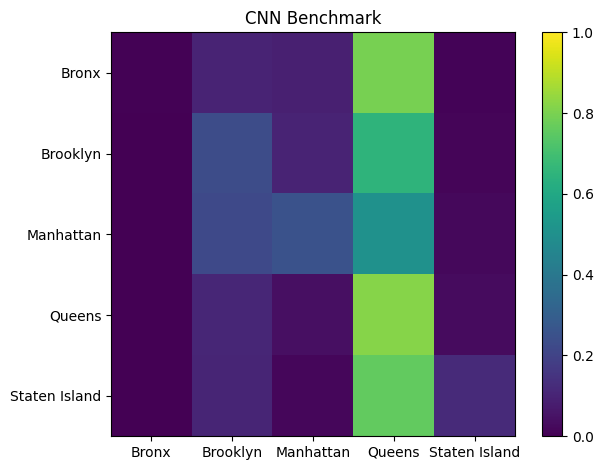

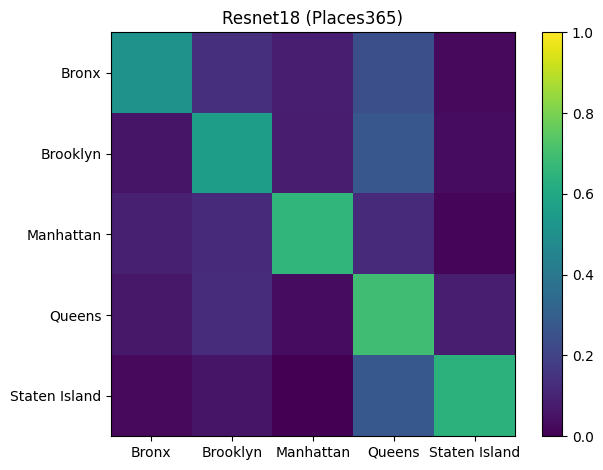

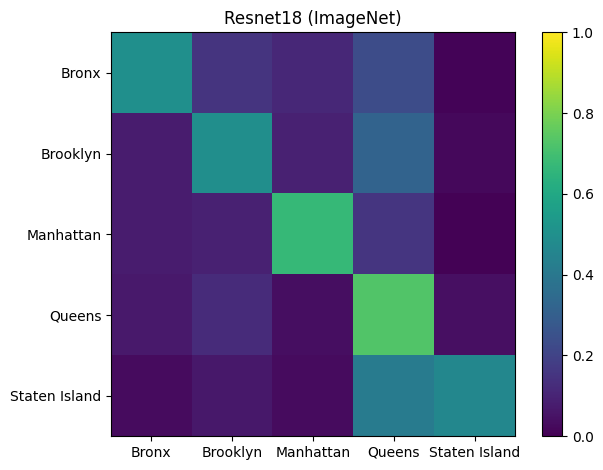

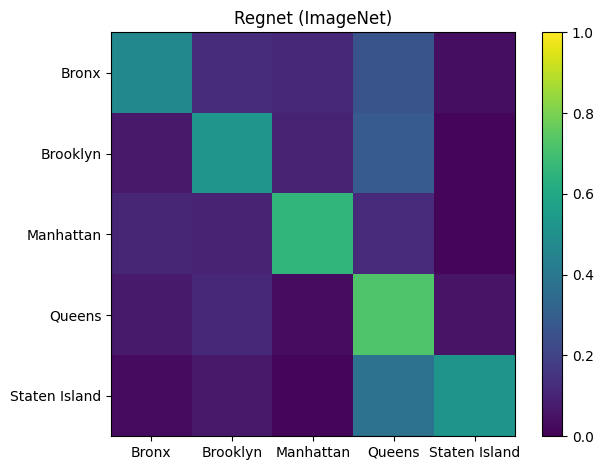

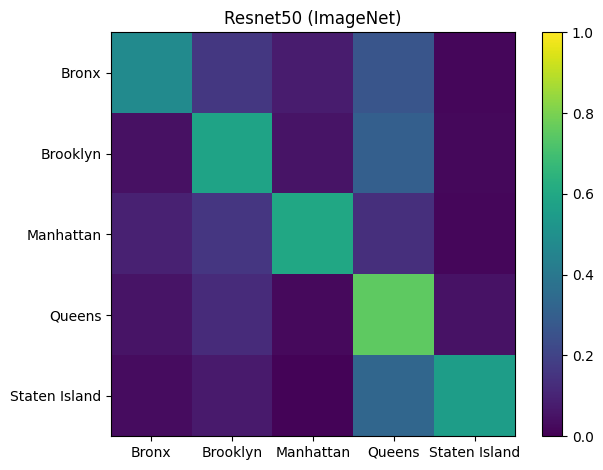

In [22]:
# Model Confusion matrices
n_total = len(test_df)
for i, model_config in enumerate(model_configs):
    model_label = model_config["label"]
    y_hat = np.argmax(model_y_hats[i], axis=-1)
    fig, ax = plot_confusion_matrix(y, y_hat, inverse_class_map, normalize=True)
    ax.set_title(model_label)
    fig.tight_layout()
    fig.savefig(os.path.join(figures_dir, f"cm_{format_label(model_label)}.png"), facecolor="white", dpi=300)
plt.show()

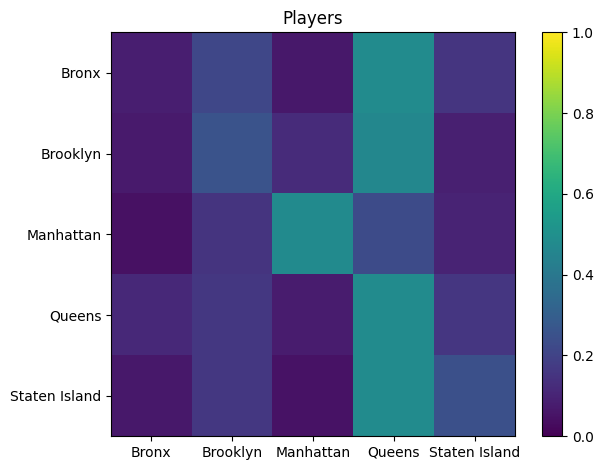

In [23]:
# Player confusion matrix
fig, ax = plot_confusion_matrix(logs_df["y"], logs_df["y_hat"], inverse_class_map, normalize=True)
ax.set_title("Players")
fig.tight_layout()
fig.savefig(os.path.join(figures_dir, f"cm_player.png"), facecolor="white", dpi=300)
plt.show()

#### By User / Model

In [24]:
user_df = logs_df.groupby("user_id")
n_users = len(user_df)
print(f"{n_users = }")
min_guesses = 10
selection = (user_df["guess"].count() > min_guesses).to_numpy() # Only users that took 10 guesses or more
user_accuracies = np.sort(user_df["correct"].mean().to_numpy()[selection])[::-1]
n_useful_users = len(user_accuracies)
print(f"{n_useful_users = }")
user_labels = [f"Player {i+1:d}" for i in np.arange(n_useful_users)]

n_users = 30
n_useful_users = 25


In [25]:
model_labels = [model_config["label"] for model_config in model_configs]

In [26]:
labels = np.concatenate([model_labels, user_labels, np.array(["Random (Uniform)", "Random (Prior)"])])
accuracies = np.concatenate([model_accuracies, user_accuracies, np.array([random_accuracy, prior_accuracy])])
colors = np.array(["tab:orange"] * len(model_labels) + ["tab:blue"] * len(user_labels) + ["tab:pink"] * 2)
legend = np.array(["Models"] + ["__"] * (len(model_labels) - 1) + ["Players"]  + ["__"] * (len(user_labels) - 1) + ["Random"] + ["__"])
print(len(accuracies), len(labels), len(colors), len(legend))

32 32 32 32


In [27]:
indices = np.argsort(accuracies)[::-1]
labels = labels[indices]
accuracies = accuracies[indices]
colors = colors[indices]
legend = legend[indices]

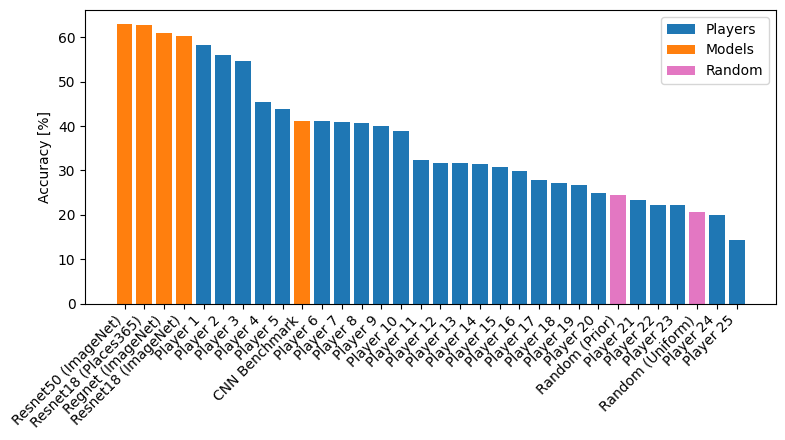

In [29]:
fig, ax = plt.subplots(figsize=(8, 4.5))
ax.bar(labels, accuracies * 100, color=colors, label=legend)
ax.legend()
ax.set_ylabel("Accuracy [%]")
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.savefig(os.path.join(figures_dir, "accuracies.png"), dpi=300, facecolor="white")
plt.show()